In [3]:
import matplotlib.pyplot as plt
import matplotlib
import itertools

import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

warnings.filterwarnings("ignore")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

train = pd.read_csv('./train.csv')
kosdaq_kospi = pd.read_csv('./stock_data/kosdaq_kospi_list.csv', encoding='euc-kr')
kospi = kosdaq_kospi["코스피"]
kosdaq = list(kosdaq_kospi["코스닥"])
adr_final = pd.read_csv('./stock_data/adr_final.csv', encoding='euc-kr') # 코스피 종목수
adr_final["Date"] = adr_final["Date"].str[1:]
adr_final["kospi_pm"]=adr_final["kospi_adr"]-adr_final["kospi_adr"].shift(1)
adr_final["kosdaq_pm"]=adr_final["kosdaq_adr"]-adr_final["kosdaq_adr"].shift(1)
 
# 추론 결과를 저장하기 위한 dataframe 생성
results_df = pd.DataFrame()

# train 데이터에 존재하는 독립적인 종목코드 추출
unique_codes = train['종목코드'].unique()

## 각 종목코드에 대해서 모델 학습 및 추론 반복
tmp = []


tc = adr_final["kospi_adr"]

model = ARIMA(tc, order=(4, 2, 4))
model_fit = model.fit()
predictions = model_fit.forecast(steps=15) # 향후 15개의 거래일에 대해서 예측



# p = range(0, 5)
# d = range(0, 5)
# q = range(0, 5)
# pdq = list(itertools.product(p, d, q))

# AIC = []
# aic = {}
# for i in pdq :
#     model = ARIMA(tc, order=(i))
#     model_fit = model.fit()
#     print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
#     AIC.append(round(model_fit.aic, 2))
#     aic[round(model_fit.aic, 2)] = i

# min(aic)


predictions

494    95.580516
495    94.430493
496    96.228596
497    94.644437
498    95.212023
499    95.438227
500    95.016788
501    94.798761
502    95.700647
503    94.440034
504    95.296890
505    95.046453
506    94.777309
507    94.927847
508    95.172218
Name: predicted_mean, dtype: float64

  1%|▏         | 25/2000 [00:02<02:41, 12.22it/s]


IndexError: list index out of range

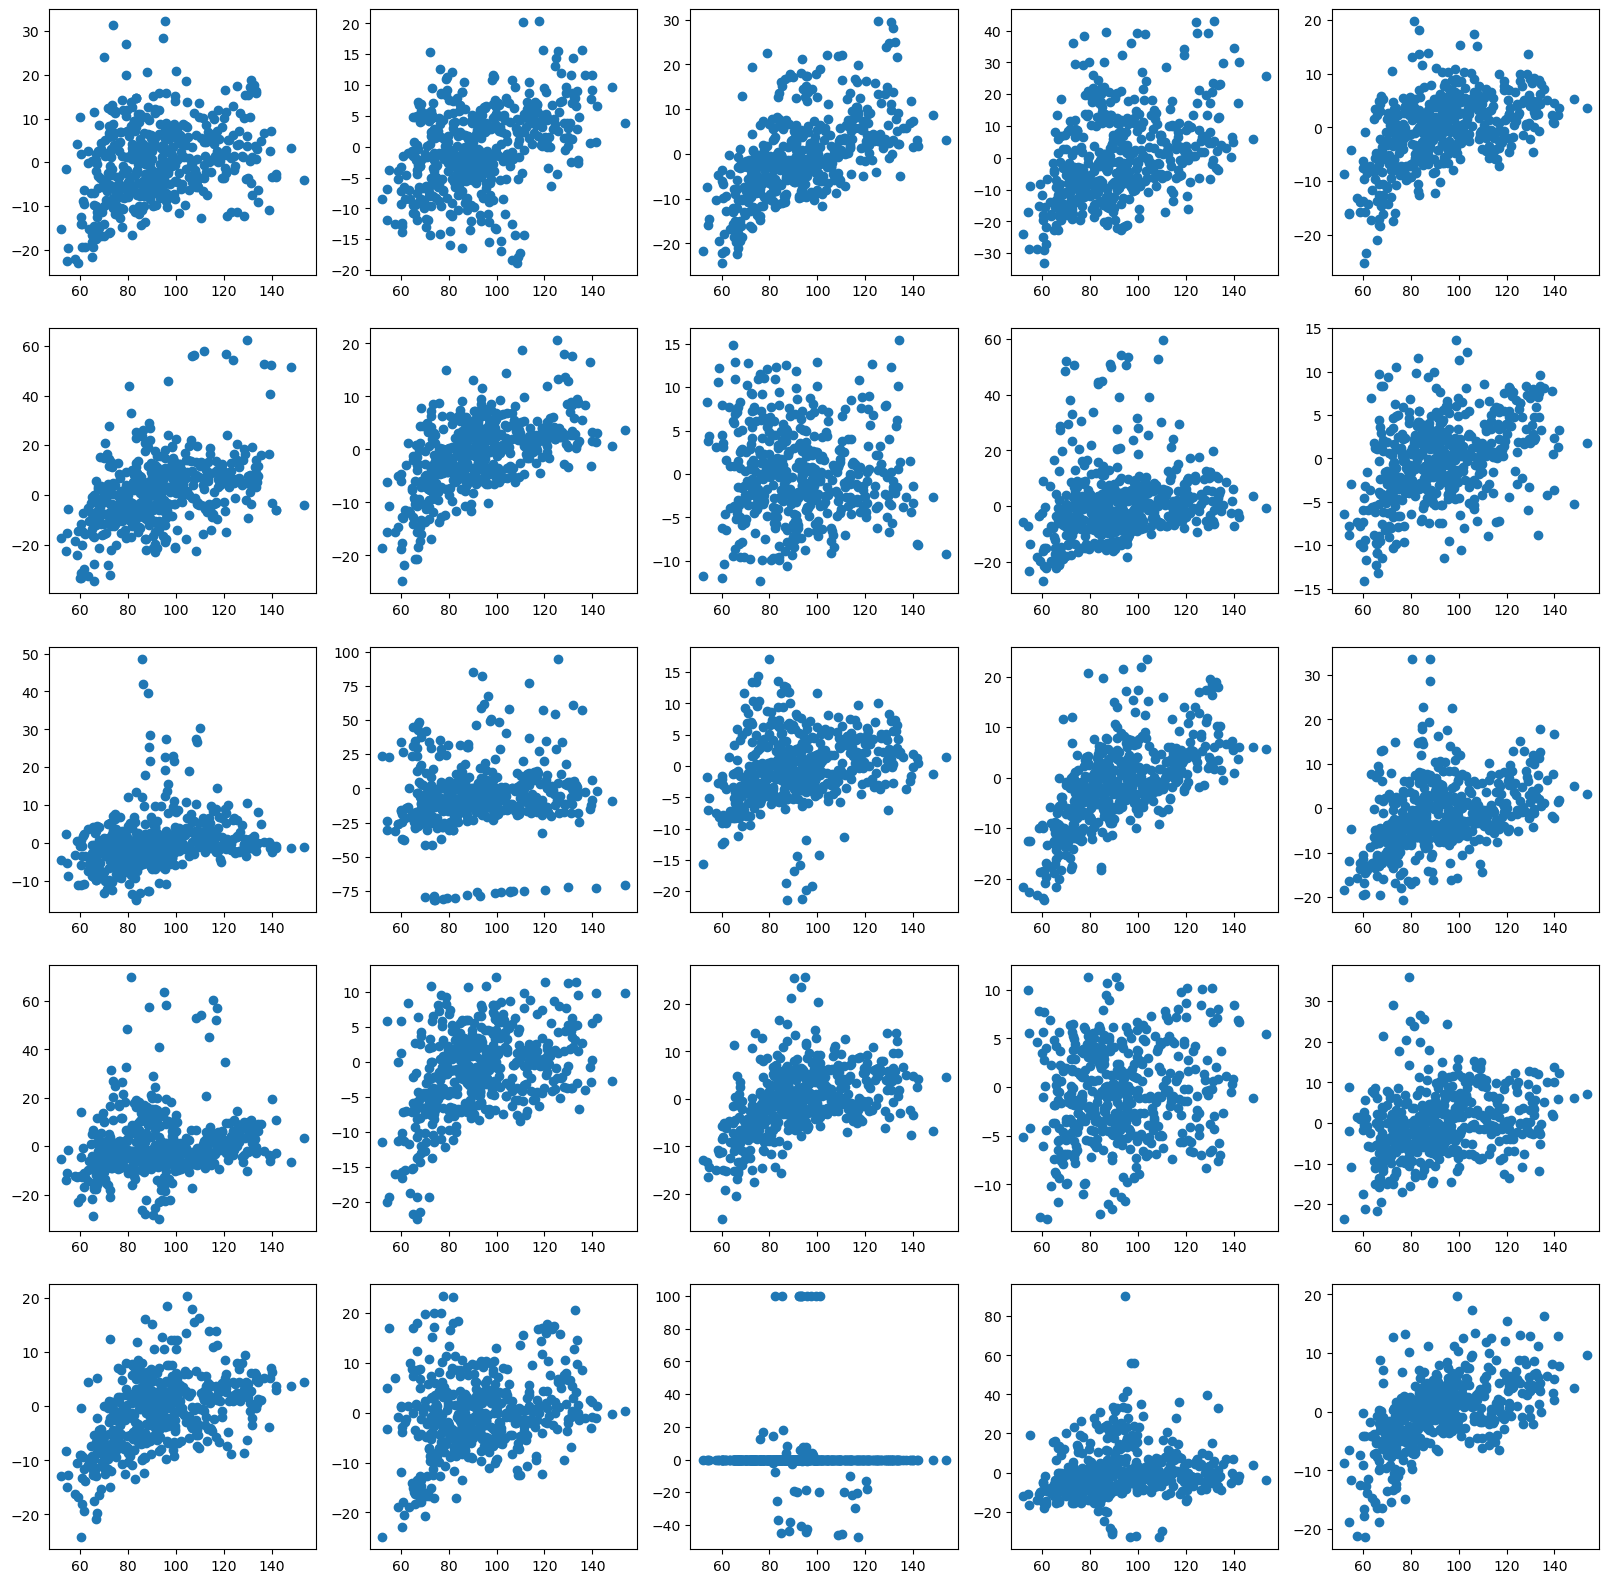

In [30]:
from sklearn.metrics import r2_score, mean_squared_error
# 각 코드에서 회귀분석
code_list = []
coef = []
intercept = []
predict = []
# for code in ['A054620']:
fig, axes = plt.subplots(5,5,figsize =(20,20))
train = pd.read_csv('./train.csv')

cnt = 0
for code in tqdm(unique_codes):
#code = "A103840"

    # 20일선 가격의 상승분과 비교
    train_close = train[train['종목코드'] == code][['일자', '종가', '종목코드']]
    #train_close['일자'] = pd.to_datetime(train_close['일자'], format='%Y%m%d')
    train_close.set_index(np.arange(len(train_close)), inplace=True)
    train_close.columns = ['Date', '종가','종목코드']
    train_close["shift"] = train_close["종가"].shift(11)
    train_close["증감"] = ((train_close["종가"] - train_close["shift"]) / train_close["shift"])*100  # 당일종가-전일종가/전일종가 로 등락폭 계산
    train_close["Date"] = train_close['Date'].astype(int)
    adr_final["Date"]=adr_final["Date"].astype(int)
    train_adr = pd.merge(left = train_close, right = adr_final, how = "inner", on = "Date")
    
    x = train_adr['kospi_adr'].iloc[11:].values.reshape(-1,1)
    y = train_adr['증감'].iloc[11:]
    fit = lr.fit(x, y)
    code_list.append(code)
    coef.append(fit.coef_)
    intercept.append(fit.intercept_)

    # score.append(r2_score(x, y))
    p = range(0, 5)
    d = range(0, 5)
    pdq = list(itertools.product(p, d))
    axes[pdq[cnt][0], pdq[cnt][1]].scatter(x, y)
    cnt += 1

# predict = map(lambda x,y: 95*x+y, coef, intercept)
result = pd.DataFrame()
result['종목코드'] = pd.Series(code_list)
# result['predict']= pd.Series(predict)


[1.35687321] [-1.69329722]
215.62650537746595 -105.6318472893771


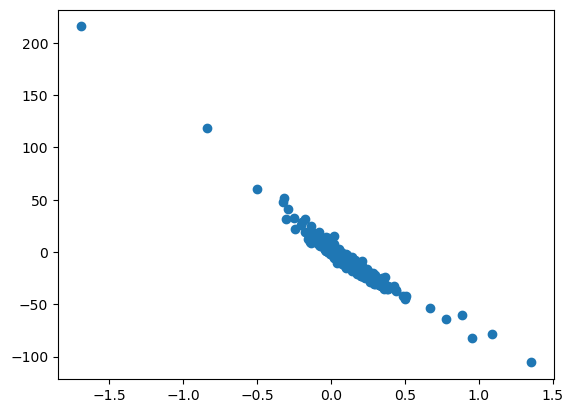

In [26]:
import pandas as pd

result['기울기'] =  pd.Series(coef)
result['절편'] =  pd.Series(intercept)
result.head(200)
print(max(coef), min(coef))
print(max(intercept), min(intercept))
plt.scatter(coef, intercept)
# 기울기와 절편은 완벽한 음의 상관관계이다.
# 기울기가 높은 것을 먼저 구하고, 절편이 낮은 것을 가져온다. 


In [27]:
result['순위'] = result['기울기'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
result = result.sort_values(by='순위')
result.to_csv('./stock_data/0721result.csv', encoding='euc-kr')

sample_submission = pd.read_csv('./sample_submission.csv')
baseline_submission = sample_submission[['종목코드']].merge(result[['종목코드', '순위']], on='종목코드', how='right')
baseline_submission.to_csv('0722_11test_submission.csv', index=False)

In [28]:
result

,종목코드,기울기,절편,순위
1667,A064520,[1.3568732075555414],-105.631847,1
606,A054180,[1.0910266495562162],-78.480375,2
1012,A123010,[0.956492487302515],-82.517014,3
1010,A101390,[0.8851456646804227],-60.201184,4
1535,A016790,[0.7806926285321633],-63.643698,5
...,...,...,...,...
1269,A064090,[-0.31678334723626367],51.362763,1996
1360,A093230,[-0.325326983848786],47.844253,1997
50,A214270,[-0.4984100090979574],60.381693,1998
1059,A263540,[-0.8370237515116352],118.235379,1999


[2.16644082] [-1.10157909]
201 226 0.016873075986787903 0.02718935871872349


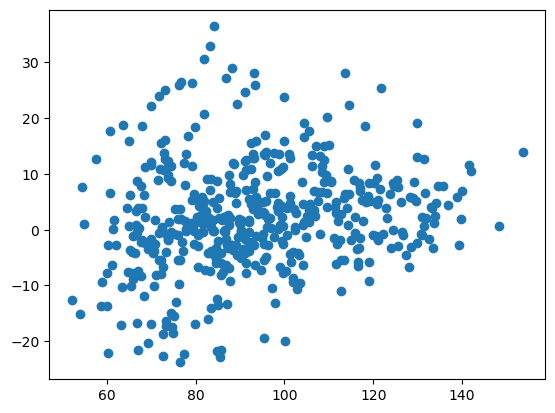

In [125]:
import numpy as np
print(max(coef), min(coef))
plt.scatter(x, y)
mcnt = 0
pcnt = 0 
for i in coef:
    if i>0.12:
        pcnt +=1
    elif i<-0.06:
        mcnt +=1
np.median(coef)
print(pcnt, mcnt, np.median(coef), np.average(coef))